# Test the Total Correlation Implementation

In [1]:
import numpy as np
import glob
import os
import ipywidgets as ipyw
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

import SimpleITK as sitk
import seaborn as sns

## Load data and visualization

In [2]:
test_img = '../data/fbMOLLI_post_dataset/train/0379217_20131018_fbMOLLI_1.npy'
img = np.load(test_img)
print(img.shape)

(20, 224, 224)


In [3]:
class ImageSliceViewer3D:
    """ 
    ImageSliceViewer3D is for viewing volumetric image slices in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image and 
    the slice plane being viewed. 

    Argumentss:
    Volume = 3D input image
    figsize = default(8,8), to set the size of the figure
    cmap = default('plasma'), string for the matplotlib colormap. You can find 
    more matplotlib colormaps on the following link:
    https://matplotlib.org/users/colormaps.html
    
    """
    
    def __init__(self, volume, figsize=(8,8), cmap='plasma'):
        self.volume = volume
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(volume), np.max(volume)]
        
        # Call to select slice plane
        ipyw.interact(self.view_selection, view=ipyw.RadioButtons(
            options=['x-y','y-z', 'z-x'], value='x-y', 
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'}))
    
    def view_selection(self, view):
        # Transpose the volume to orient according to the slice plane selection
        orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
        self.vol = np.transpose(self.volume, orient[view])
        maxZ = self.vol.shape[2] - 1
        
        # Call to view a slice within the selected slice plane
        ipyw.interact(self.plot_slice, 
            z=ipyw.IntSlider(min=0, max=maxZ, step=1, continuous_update=False, 
            description='Image Slice:'))
        
    def plot_slice(self, z):
        # Plot slice for the given plane and slice
        self.fig = plt.figure(figsize=self.figsize)
        plt.imshow(self.vol[:,:,z], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])


In [4]:
# ImageSliceViewer3D(img)

## Check the total correlation

In [5]:
import torch

class JointCorrelation():
    def __init__(self, eps=0.5):
        super(JointCorrelation, self).__init__()
        self.eps = eps
    

    def loss(self, invols):
        # fig = plt.figure(figsize=(6,6))
        n_imgs = invols.shape[0]

        M = torch.transpose(torch.squeeze(torch.flatten(invols, start_dim=1, end_dim=-1)), 0, 1) # M = [n, c, h, w] -> [c*h*w, n]
        
#         M_avg = torch.mean(M, dim=1, keepdim=True) # [c*h*w, 1]
#         M_avg = torch.tile(M_avg, (1, n_imgs)) # [c*h*w, n]

#         C = (M - M_avg).T @ (M - M_avg) / (n_imgs - 1) # [n, n]
        # ax1 = fig.add_subplot(2, 2, 1)
        # plt.imshow(C)

        # M_std = torch.std(M, dim=0)
        # Sigma_inv = torch.diag(1/M_std)
        # ax2 = fig.add_subplot(2, 2, 2)
        # plt.imshow(Sigma_inv)
        # K = Sigma_inv @ C @ Sigma_inv
        # ax3 = fig.add_subplot(2, 2, 3)
        # plt.imshow(K)
        KK = torch.corrcoef(M.T)
        # ax4 = fig.add_subplot(2, 2, 4)
        # plt.imshow(KK)

        # eigenvalues = torch.real(torch.linalg.eigvals(K))
        eigenvalues1 = torch.real(torch.linalg.eigvals(KK))
        # print(f"eigenvalues: {eigenvalues}")
        print(f"eigenvalues1: {eigenvalues1}")
        dissimilarity = 0.5 * torch.nansum(torch.log(eigenvalues1 + self.eps))
        return dissimilarity, eigenvalues1
    
    
total_correlation = JointCorrelation()

### Original volume

eigenvalues1: tensor([1.7152e+01, 1.7423e+00, 4.5879e-01, 3.2182e-01, 7.7053e-02, 6.8427e-02,
        4.0174e-02, 2.4962e-02, 2.1808e-02, 1.8769e-02, 1.3537e-02, 1.1110e-02,
        9.2466e-03, 8.6261e-03, 6.9175e-03, 6.2869e-03, 5.8159e-03, 4.6702e-03,
        3.9900e-03, 3.2293e-03], dtype=torch.float64)
Total Correlation is -3.513777847547268


<AxesSubplot: >

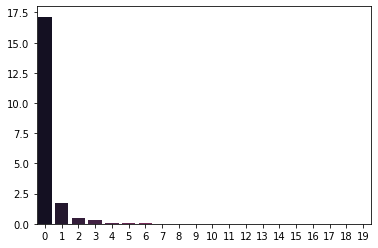

In [6]:
test_input = img[:, None, ...]
correlation, eigs = total_correlation.loss(torch.from_numpy(test_input))
print(f"Total Correlation is {correlation}")
sns.barplot(x=np.arange(len(eigs)), y=np.around(eigs.detach().cpu().numpy(), 2), palette="rocket")

### Fixed volume

(20, 224, 224)
eigenvalues1: tensor([  2.0000e+01,   8.3904e-14,   5.0199e-14,  -1.4864e-16,  -3.9385e-30,
          1.2558e-31,   1.2558e-31,  -7.6916e-32,   3.1561e-48,   3.1561e-48,
         -6.3612e-65,   3.7023e-80,  -1.6487e-82,  -4.8023e-98, -7.9702e-101,
         2.4707e-115, -1.6791e-119,   0.0000e+00,   0.0000e+00,   0.0000e+00],
       dtype=torch.float64)
Total Correlation is -5.074685772247169


<AxesSubplot: >

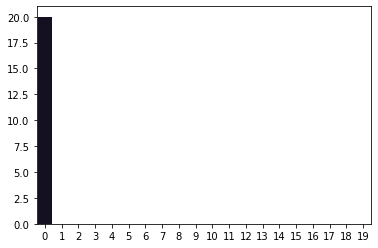

In [7]:
tmp = img[0,:,:]
test_fix = np.repeat(tmp[None,...], 20, axis=0)
print(test_fix.shape)
# ImageSliceViewer3D(test_fix)

correlation, eigs = total_correlation.loss(torch.from_numpy(test_fix))
print(f"Total Correlation is {correlation}")
sns.barplot(x=np.arange(len(eigs)), y=np.around(eigs.detach().cpu().numpy(), 2), palette="rocket")

### RPCA low rank matrix

In [8]:
from hyperspy.learn.rpca import rpca_godec, orpca

vols = img.transpose(1, 2, 0)
x, y, z = vols.shape
print(f"Shape of array is {vols.shape}")
M = vols.reshape(x*y, z)
print(M.shape)

Shape of array is (224, 224, 20)
(50176, 20)


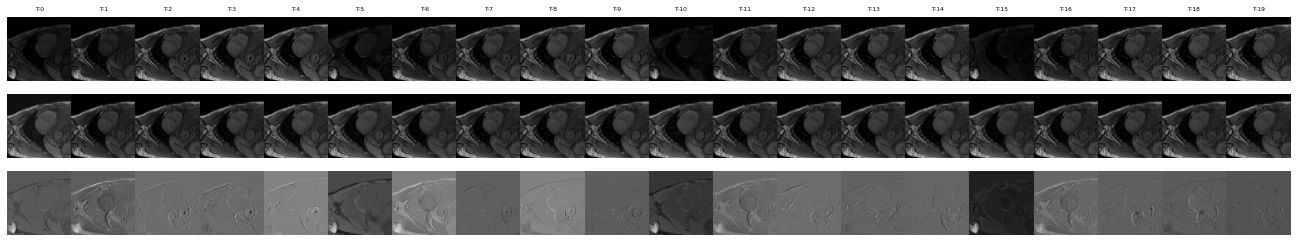

In [18]:
rank = 2
low, sparse, U, S, V = rpca_godec(M, rank=rank)
low_matrix = low.reshape((x, y, z))
sparse_matrix = sparse.reshape((x, y, z))

path = 'test_rpca'
sitk.WriteImage(sitk.GetImageFromArray(low_matrix.transpose(2, 0, 1)), os.path.join(path, f"lowrank-{rank}.nii"))
sitk.WriteImage(sitk.GetImageFromArray(sparse_matrix.transpose(2, 0, 1)), os.path.join(path, f"sparse-{rank}.nii"))
sitk.WriteImage(sitk.GetImageFromArray(vols.transpose(2, 0, 1)), os.path.join(path, "original.nii"))

# ImageSliceViewer3D(low_matrix)
# ImageSliceViewer3D(sparse_matrix)
fig = plt.figure(figsize=(18,4))
slices = np.arange(0, 20, 1)
for i in range(len(slices)):
    ax1 = fig.add_subplot(3, len(slices), 1+i)
    ax1.imshow(vols[:,:,slices[i]], cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'T-{slices[i]}', fontsize=6)

    ax2 = fig.add_subplot(3, len(slices), 21+i)
    ax2.imshow(low_matrix[..., slices[i]], cmap='gray')
    ax2.axis('off')
    ax3 = fig.add_subplot(3, len(slices), 41+i)
    ax3.imshow(sparse_matrix[..., slices[i]], cmap='gray')
    ax3.axis('off')
plt.subplots_adjust(left=0.0001, right=0.99, top=0.9, bottom=0.1, wspace=0.001, hspace=0.000001)

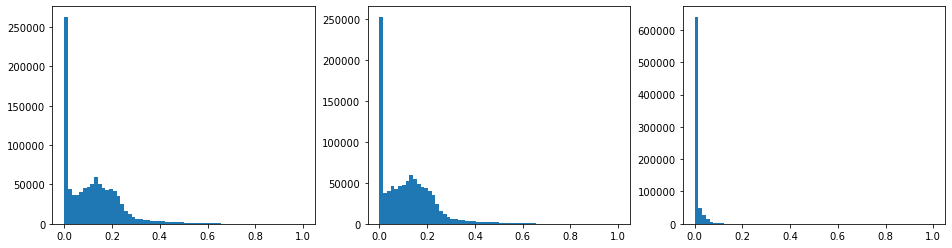

In [19]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.hist(vols.flatten(), bins=64, range=(0, 1)) 

ax2 = fig.add_subplot(1, 3, 2)
ax2.hist(low_matrix.flatten(), bins=64, range=(0, 1)) 

ax3 = fig.add_subplot(1, 3, 3)
ax3.hist(sparse.flatten(), bins=64, range=(0, 1)) 
plt.show()

#### Test the low rank matrix's total correlation

eigenvalues1: tensor([1.9301e+01, 6.5363e-01, 1.8733e-02, 1.0145e-02, 3.5818e-03, 2.4157e-03,
        1.6757e-03, 1.6265e-03, 1.0107e-03, 8.3717e-04, 7.4823e-04, 7.0942e-04,
        3.7450e-04, 4.1570e-04, 4.2762e-04, 4.6247e-04, 6.0917e-04, 5.6541e-04,
        5.2651e-04, 5.3957e-04], dtype=torch.float64)
Total Correlation is -4.629072222526012


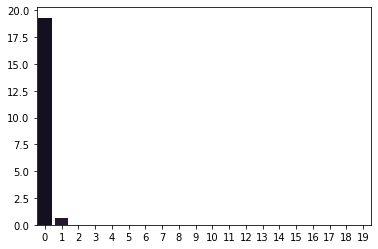

In [20]:
correlation, eigs = total_correlation.loss(torch.from_numpy(low_matrix[None, ...].transpose(3, 0, 1, 2)))
print(f"Total Correlation is {correlation}")
sns.barplot(x=np.arange(len(eigs)), y=np.around(eigs.detach().cpu().numpy(), 2), palette="rocket")
plt.show()

#### Test the low rank matrix's total correlation

eigenvalues1: tensor([4.6865, 3.5918, 2.9006, 1.5540, 1.2743, 1.0499, 0.9133, 0.8076, 0.6945,
        0.5295, 0.5128, 0.3758, 0.2798, 0.2258, 0.1953, 0.1592, 0.0278, 0.0905,
        0.0754, 0.0556], dtype=torch.float64)
Total Correlation is 1.527948808020759


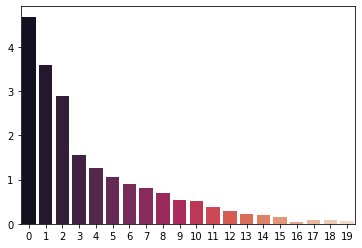

In [21]:
correlation, eigs = total_correlation.loss(torch.from_numpy(sparse_matrix[None, ...].transpose(3, 0, 1, 2)))
print(f"Total Correlation is {correlation}")
sns.barplot(x=np.arange(len(eigs)), y=np.around(eigs.detach().cpu().numpy(), 2), palette="rocket")
plt.show()

### Test equalization and normalization

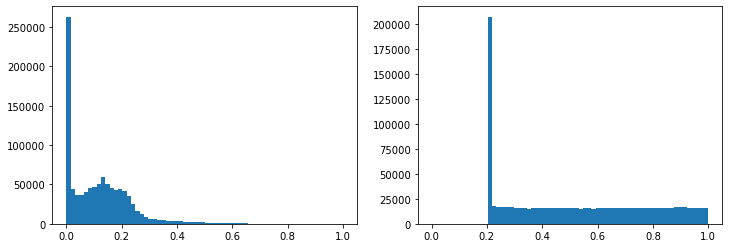

In [13]:
from skimage import exposure
eq_img = exposure.equalize_hist(img)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(img.flatten(), bins=64, range=(0, 1)) 

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq_img.flatten(), bins=64, range=(0, 1)) 
plt.show()

#### Test the equalization matrix's total correlation

eigenvalues1: tensor([1.7005e+01, 1.4044e+00, 5.4927e-01, 5.0550e-01, 1.2891e-01, 1.2050e-01,
        6.3511e-02, 4.7480e-02, 3.2380e-02, 3.1239e-02, 2.0569e-02, 1.7472e-02,
        1.4433e-02, 4.6400e-03, 5.8955e-03, 1.2395e-02, 7.1938e-03, 1.1097e-02,
        9.1944e-03, 9.3616e-03], dtype=torch.float64)
Total Correlation is -3.2648082659328512


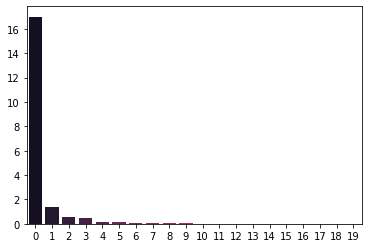

In [14]:
correlation, eigs = total_correlation.loss(torch.from_numpy(eq_img[None, ...].transpose(1, 0, 2, 3)))
print(f"Total Correlation is {correlation}")
sns.barplot(x=np.arange(len(eigs)), y=np.around(eigs.detach().cpu().numpy(), 2), palette="rocket")
plt.show()

(20, 224, 224)


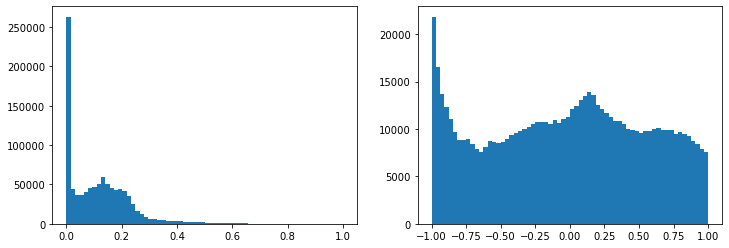

In [15]:
norm_img = sitk.GetArrayFromImage(sitk.Normalize(sitk.GetImageFromArray(img)))
print(norm_img.shape)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(img.flatten(), bins=64, range=(0, 1)) 

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(norm_img.flatten(), bins=64, range=(-1, 1)) 
plt.show()

#### Test the normalization matrix's total correlation

eigenvalues1: tensor([1.7152e+01, 1.7423e+00, 4.5879e-01, 3.2182e-01, 7.7053e-02, 6.8427e-02,
        4.0174e-02, 2.4962e-02, 2.1808e-02, 1.8769e-02, 1.3537e-02, 1.1110e-02,
        9.2466e-03, 8.6261e-03, 6.9175e-03, 6.2869e-03, 5.8159e-03, 4.6702e-03,
        3.9900e-03, 3.2293e-03], dtype=torch.float64)
Total Correlation is -3.5137778475472814


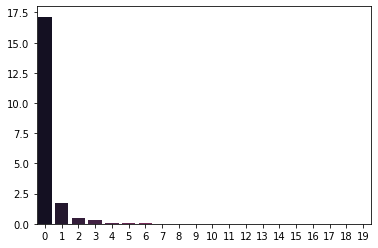

In [16]:
correlation, eigs = total_correlation.loss(torch.from_numpy(norm_img[None, ...].transpose(1, 0, 2, 3)))
print(f"Total Correlation is {correlation}")
sns.barplot(x=np.arange(len(eigs)), y=np.around(eigs.detach().cpu().numpy(), 2), palette="rocket")
plt.show()

In [17]:
ImageSliceViewer3D(norm_img.transpose(1, 2, 0))

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…